# 6장. 임베딩을 사용한 감성 프로그래밍

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://nbviewer.jupyter.org/github/rickiepark/aiml4coders/blob/main/ch06/06-sentiment-analysis.ipynb"><img src="https://jupyter.org/assets/share.png" width="61" />주피터 노트북 뷰어로 보기</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/aiml4coders/blob/main/ch06/06-sentiment-analysis.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩(Colab)에서 실행하기</a>
  </td>
</table>

In [ ]:
# 노트북이 코랩에서 실행 중인지 체크합니다.
import sys
if 'google.colab' in sys.modules:
    !wget -q https://github.com/rickiepark/aiml4coders/raw/main/ch05/sarcasm.json
    !mkdir ../ch05
    !mv sarcasm.json ../ch05

## Sarcasm 데이터셋 로딩 및 전처리

In [1]:
import json
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import string
import tensorflow as tf

In [2]:
stopwords = ["a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at",
             "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do",
             "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having",
             "he", "hed", "hes", "her", "here", "heres", "hers", "herself", "him", "himself", "his", "how",
             "hows", "i", "id", "ill", "im", "ive", "if", "in", "into", "is", "it", "its", "itself",
             "lets", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought",
             "our", "ours", "ourselves", "out", "over", "own", "same", "she", "shed", "shell", "shes", "should",
             "so", "some", "such", "than", "that", "thats", "the", "their", "theirs", "them", "themselves", "then",
             "there", "theres", "these", "they", "theyd", "theyll", "theyre", "theyve", "this", "those", "through",
             "to", "too", "under", "until", "up", "very", "was", "we", "wed", "well", "were", "weve", "were",
             "what", "whats", "when", "whens", "where", "wheres", "which", "while", "who", "whos", "whom", "why",
             "whys", "with", "would", "you", "youd", "youll", "youre", "youve", "your", "yours", "yourself",
             "yourselves"]

table = str.maketrans('', '', string.punctuation)

In [3]:
with open("../ch05/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = [] 
labels = []
urls = []
for item in datastore:
    sentence = item['headline'].lower()
    sentence = sentence.replace(",", " , ")
    sentence = sentence.replace(".", " . ")
    sentence = sentence.replace("-", " - ")
    sentence = sentence.replace("/", " / ")
    soup = BeautifulSoup(sentence)
    sentence = soup.get_text()
    words = sentence.split()
    filtered_sentence = ""
    for word in words:
        word = word.translate(table)
        if word not in stopwords:
            filtered_sentence = filtered_sentence + word + " "
    sentences.append(filtered_sentence)
    labels.append(item['is_sarcastic'])
    urls.append(item['article_link'])

In [4]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 23000

In [5]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [6]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## 텐서플로의 임베딩

### 임베딩을 사용해 빈정거림 감지기 만들기

In [8]:
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 24)                408       
                                                                 
 dense_1 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


In [11]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 2s 2ms/step - loss: 0.6794 - accuracy: 0.5627 - val_loss: 0.6482 - val_accuracy: 0.5958
Epoch 2/30
719/719 [==============================] - 2s 2ms/step - loss: 0.5394 - accuracy: 0.7441 - val_loss: 0.4723 - val_accuracy: 0.7743
Epoch 3/30
719/719 [==============================] - 1s 2ms/step - loss: 0.3864 - accuracy: 0.8352 - val_loss: 0.4345 - val_accuracy: 0.7970
Epoch 4/30
719/719 [==============================] - 1s 2ms/step - loss: 0.3234 - accuracy: 0.8623 - val_loss: 0.4206 - val_accuracy: 0.8016
Epoch 5/30
719/719 [==============================] - 2s 2ms/step - loss: 0.2849 - accuracy: 0.8812 - val_loss: 0.4239 - val_accuracy: 0.8078
Epoch 6/30
719/719 [==============================] - 2s 2ms/step - loss: 0.2603 - accuracy: 0.8928 - val_loss: 0.4479 - val_accuracy: 0.7948
Epoch 7/30
719/719 [==============================] - 2s 2ms/step - loss: 0.2381 - accuracy: 0.9027 - val_loss: 0.4553 - val_accuracy: 0.8067
Epoch 

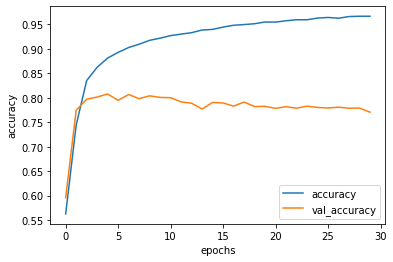

In [12]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

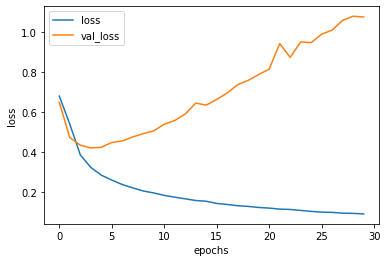

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

### 언어 모델의 과대적합 줄이기

#### 학습률 조정하기

In [14]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, 
                               beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='binary_crossentropy',
              optimizer=adam, metrics=['accuracy'])

history = model.fit(training_padded, training_labels, epochs=100,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6900 - accuracy: 0.5558 - val_loss: 0.6857 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6860 - accuracy: 0.5596 - val_loss: 0.6831 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6849 - accuracy: 0.5596 - val_loss: 0.6823 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6844 - accuracy: 0.5596 - val_loss: 0.6816 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6836 - accuracy: 0.5596 - val_loss: 0.6809 - val_accuracy: 0.5700
Epoch 6/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6823 - accuracy: 0.5596 - val_loss: 0.6792 - val_accuracy: 0.5700
Epoch 7/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6803 - accuracy: 0.5596 - val_loss: 0.6770 - val_accuracy: 0.5700

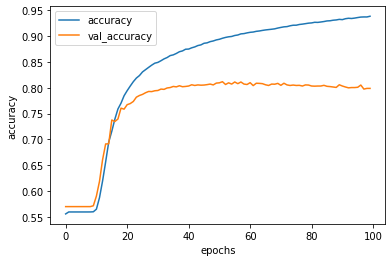

In [15]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

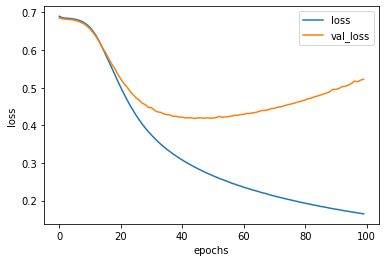

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 어휘 사전 크기 바꾸기

In [ ]:
wc=tokenizer.word_counts
# 출력이 길어 노트북에서 제외함
print(wc)

In [ ]:
from collections import OrderedDict
newlist = (OrderedDict(sorted(wc.items(), key=lambda t: t[1], reverse=True)))
# 출력이 길어 노트북에서 제외함
print(newlist)

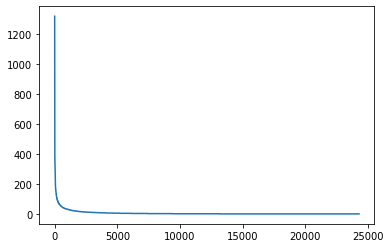

In [19]:
xs=[]
ys=[]
curr_x = 1
for item in newlist:
  xs.append(curr_x)
  curr_x=curr_x+1
  ys.append(newlist[item])

plt.plot(xs,ys)
plt.show()

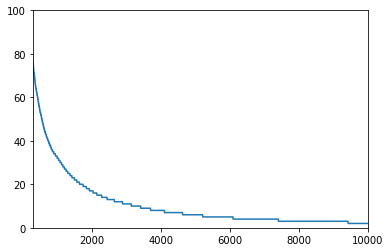

In [20]:
plt.plot(xs,ys)
plt.axis([300,10000,0,100])
plt.show()

In [21]:
vocab_size = 2000

In [22]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [23]:
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [25]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/30
719/719 [==============================] - 2s 2ms/step - loss: 0.6776 - accuracy: 0.5663 - val_loss: 0.6418 - val_accuracy: 0.6188
Epoch 2/30
719/719 [==============================] - 1s 2ms/step - loss: 0.5621 - accuracy: 0.7137 - val_loss: 0.5053 - val_accuracy: 0.7563
Epoch 3/30
719/719 [==============================] - 1s 2ms/step - loss: 0.4648 - accuracy: 0.7776 - val_loss: 0.4750 - val_accuracy: 0.7627
Epoch 4/30
719/719 [==============================] - 1s 2ms/step - loss: 0.4328 - accuracy: 0.7925 - val_loss: 0.4650 - val_accuracy: 0.7708
Epoch 5/30
719/719 [==============================] - 1s 2ms/step - loss: 0.4181 - accuracy: 0.8018 - val_loss: 0.4624 - val_accuracy: 0.7749
Epoch 6/30
719/719 [==============================] - 1s 2ms/step - loss: 0.4101 - accuracy: 0.8034 - val_loss: 0.4624 - val_accuracy: 0.7768
Epoch 7/30
719/719 [==============================] - 1s 2ms/step - loss: 0.4040 - accuracy: 0.8069 - val_loss: 0.4681 - val_accuracy: 0.7816
Epoch 

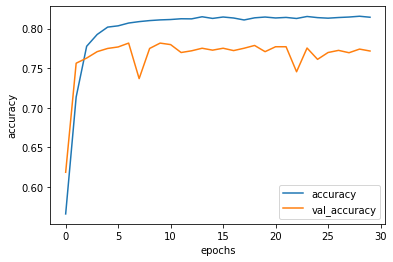

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

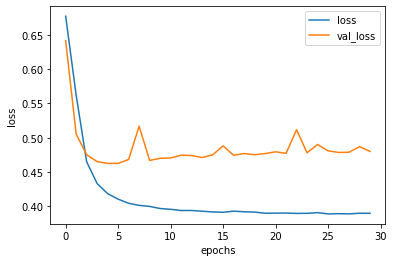

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 임베딩 차원 바꾸기

In [28]:
embedding_dim = 7

In [29]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [30]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6831 - accuracy: 0.5592 - val_loss: 0.6734 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6134 - accuracy: 0.6600 - val_loss: 0.5460 - val_accuracy: 0.7296
Epoch 3/100
719/719 [==============================] - 1s 1ms/step - loss: 0.4935 - accuracy: 0.7649 - val_loss: 0.4834 - val_accuracy: 0.7627
Epoch 4/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4457 - accuracy: 0.7863 - val_loss: 0.4803 - val_accuracy: 0.7582
Epoch 5/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4257 - accuracy: 0.7970 - val_loss: 0.4630 - val_accuracy: 0.7741
Epoch 6/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4154 - accuracy: 0.8011 - val_loss: 0.4620 - val_accuracy: 0.7749
Epoch 7/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4090 - accuracy: 0.8056 - val_loss: 0.4618 - val_accuracy: 0.7768

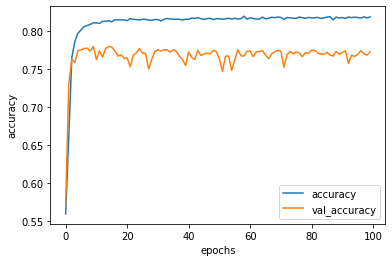

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

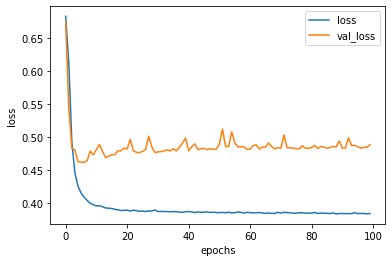

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 모델 구조 변경하기

In [33]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [34]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6834 - accuracy: 0.5596 - val_loss: 0.6741 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6485 - accuracy: 0.6126 - val_loss: 0.6092 - val_accuracy: 0.6813
Epoch 3/100
719/719 [==============================] - 1s 2ms/step - loss: 0.5629 - accuracy: 0.7216 - val_loss: 0.5360 - val_accuracy: 0.7385
Epoch 4/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4941 - accuracy: 0.7677 - val_loss: 0.4929 - val_accuracy: 0.7603
Epoch 5/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4577 - accuracy: 0.7863 - val_loss: 0.4752 - val_accuracy: 0.7660
Epoch 6/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4371 - accuracy: 0.7934 - val_loss: 0.4772 - val_accuracy: 0.7611
Epoch 7/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4242 - accuracy: 0.7986 - val_loss: 0.4632 - val_accuracy: 0.7735

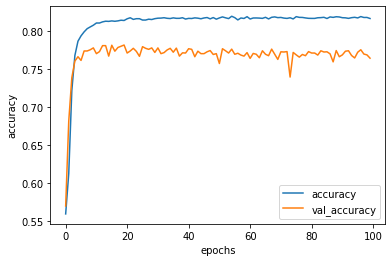

In [35]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

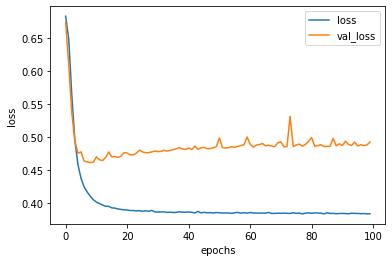

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 드롭아웃 사용하기

In [37]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dropout(.25),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [38]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 2s 2ms/step - loss: 0.6847 - accuracy: 0.5591 - val_loss: 0.6767 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6602 - accuracy: 0.6019 - val_loss: 0.6307 - val_accuracy: 0.6840
Epoch 3/100
719/719 [==============================] - 1s 2ms/step - loss: 0.5991 - accuracy: 0.6742 - val_loss: 0.5627 - val_accuracy: 0.7358
Epoch 4/100
719/719 [==============================] - 1s 2ms/step - loss: 0.5404 - accuracy: 0.7264 - val_loss: 0.5154 - val_accuracy: 0.7563
Epoch 5/100
719/719 [==============================] - 1s 2ms/step - loss: 0.5074 - accuracy: 0.7557 - val_loss: 0.4923 - val_accuracy: 0.7662
Epoch 6/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4826 - accuracy: 0.7750 - val_loss: 0.4812 - val_accuracy: 0.7671
Epoch 7/100
719/719 [==============================] - 1s 2ms/step - loss: 0.4700 - accuracy: 0.7833 - val_loss: 0.4765 - val_accuracy: 0.7724

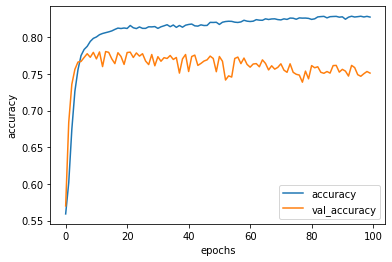

In [39]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

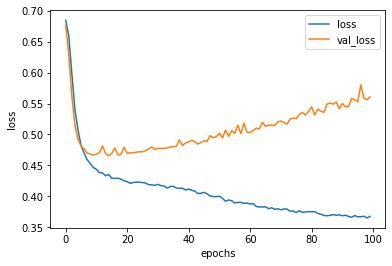

In [40]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 규제 사용하기

In [41]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(8, activation='relu', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',
              optimizer='adam',metrics=['accuracy'])

In [42]:
num_epochs = 100
history = model.fit(training_padded, training_labels, epochs=num_epochs,
                    validation_data=(testing_padded, testing_labels))

Epoch 1/100
719/719 [==============================] - 2s 2ms/step - loss: 0.7037 - accuracy: 0.5591 - val_loss: 0.6845 - val_accuracy: 0.5700
Epoch 2/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6860 - accuracy: 0.5596 - val_loss: 0.6832 - val_accuracy: 0.5700
Epoch 3/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6854 - accuracy: 0.5596 - val_loss: 0.6825 - val_accuracy: 0.5700
Epoch 4/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6834 - accuracy: 0.5596 - val_loss: 0.6787 - val_accuracy: 0.5700
Epoch 5/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6749 - accuracy: 0.5596 - val_loss: 0.6654 - val_accuracy: 0.5700
Epoch 6/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6550 - accuracy: 0.6152 - val_loss: 0.6441 - val_accuracy: 0.6525
Epoch 7/100
719/719 [==============================] - 1s 2ms/step - loss: 0.6300 - accuracy: 0.6780 - val_loss: 0.6225 - val_accuracy: 0.7050

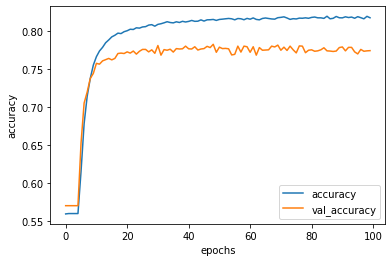

In [43]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

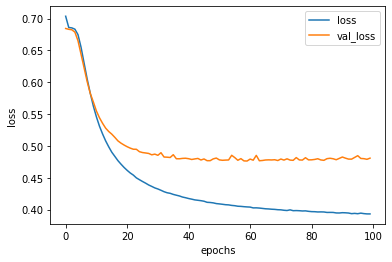

In [44]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

#### 다른 고려 사항

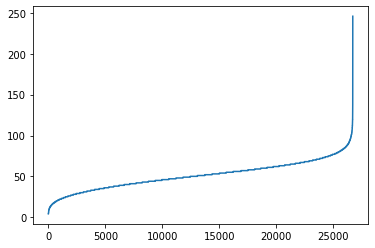

In [45]:
xs=[]
ys=[]
current_item=1
for item in sentences:
    xs.append(current_item)
    current_item=current_item+1
    ys.append(len(item))
newys = sorted(ys)

plt.plot(xs,newys)
plt.show()

### 모델을 사용해 문장 분류하기

In [46]:
sentences = ["granny starting to fear spiders in the garden might be real", 
             "game of thrones season finale showing this sunday night", 
             "TensorFlow book will be a best seller"]

In [47]:
sequences = tokenizer.texts_to_sequences(sentences)
print(sequences)

[[1, 803, 1, 753, 1, 1, 1, 1, 312, 1, 97], [123, 1, 1183, 160, 1, 1, 1, 1543, 152], [1, 235, 7, 1, 1, 47, 1]]


In [48]:
padded = pad_sequences(sequences, maxlen=max_length, 
                       padding=padding_type, truncating=trunc_type)
print(padded)

[[   1  803    1  753    1    1    1    1  312    1   97    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [ 123    1 1183  160    1    1    1 1543  152    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0

In [49]:
print(model.predict(padded))

[[0.74510473]
 [0.03688553]
 [0.17497352]]


## 임베딩 시각화

In [50]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape)

(2000, 7)


In [51]:
print(tokenizer.index_word[2])
print(weights[2])

new
[-0.91460747 -0.64408696  1.123625    0.5669758   0.7248215   1.0291427
 -0.7931584 ]


In [52]:
import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8')
out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for word_num in range(1, vocab_size):
    word = tokenizer.index_word[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
out_v.close()
out_m.close()

## 텐서플로 허브에서 사전 훈련된 임베딩 사용하기

In [53]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1", 
    output_shape=[20], input_shape=[], 
    dtype=tf.string, trainable=False
)

In [54]:
model = tf.keras.Sequential([
    hub_layer,
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

adam = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, 
                                beta_2=0.999, amsgrad=False)

model.compile(loss='binary_crossentropy',optimizer=adam, 
              metrics=['accuracy'])

In [55]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 20)                400020    
                                                                 
 dense_14 (Dense)            (None, 16)                336       
                                                                 
 dense_15 (Dense)            (None, 1)                 17        
                                                                 
Total params: 400,373
Trainable params: 353
Non-trainable params: 400,020
_________________________________________________________________


In [60]:
# 넘파이 배열로 바뀐 레이블을 다시 리스트로 변경합니다.
training_labels = training_labels.tolist()
testing_labels = testing_labels.tolist()

In [61]:
num_epochs = 50
history = model.fit(training_sentences, training_labels, epochs=num_epochs,
                    validation_data=(testing_sentences, testing_labels))

Epoch 1/50
719/719 [==============================] - 1s 2ms/step - loss: 0.7092 - accuracy: 0.5475 - val_loss: 0.6812 - val_accuracy: 0.5829
Epoch 2/50
719/719 [==============================] - 1s 1ms/step - loss: 0.6737 - accuracy: 0.5930 - val_loss: 0.6632 - val_accuracy: 0.6134
Epoch 3/50
719/719 [==============================] - 1s 2ms/step - loss: 0.6608 - accuracy: 0.6136 - val_loss: 0.6547 - val_accuracy: 0.6263
Epoch 4/50
719/719 [==============================] - 1s 1ms/step - loss: 0.6540 - accuracy: 0.6262 - val_loss: 0.6495 - val_accuracy: 0.6360
Epoch 5/50
719/719 [==============================] - 1s 2ms/step - loss: 0.6493 - accuracy: 0.6308 - val_loss: 0.6455 - val_accuracy: 0.6446
Epoch 6/50
719/719 [==============================] - 1s 2ms/step - loss: 0.6457 - accuracy: 0.6363 - val_loss: 0.6422 - val_accuracy: 0.6498
Epoch 7/50
719/719 [==============================] - 1s 2ms/step - loss: 0.6426 - accuracy: 0.6393 - val_loss: 0.6395 - val_accuracy: 0.6527
Epoch 

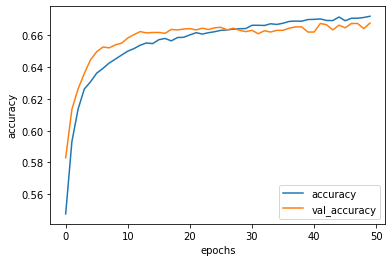

In [62]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

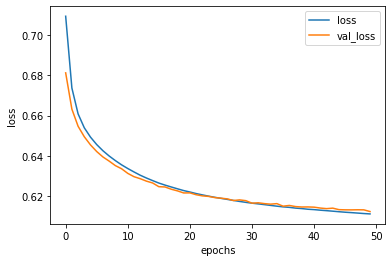

In [63]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()